In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [3]:
year_embeddings = []
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
# Get the vocab matrix row for each year_fill_token_id
# This is typically the embedding layer's weight matrix
embedding_matrix = model.get_input_embeddings().weight.detach().cpu()
for token_id in year_fill_token_ids:
    year_embeddings.append(embedding_matrix[token_id])



In [10]:
import numpy as np
from matplotlib import pyplot as plt
# Convert to numpy array
year_matrix = np.stack(year_embeddings)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
year_pca = pca.fit_transform(year_matrix)

'''
for i in range(3):
    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(years, year_pca[:, i], c=range(1990, 2020), cmap='viridis')
    plt.colorbar(label='Year')
    plt.xlabel('Year')
    plt.ylabel('{} PC'.format(i+1))
    plt.title('PCA of Year Embeddings')
    plt.show()
'''

# Download and set the Junicode font
font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
import urllib.request
import matplotlib.font_manager as fm
urllib.request.urlretrieve(font_url, font_path)
junicode_prop = fm.FontProperties(fname=font_path)


import plotly.graph_objs as go
colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

custom_colorscale = [[0, colorscale_min], [1, colorscale_max]]

fig = go.Figure(data=[go.Scatter3d(
    x=year_pca[:, 0],
    y=year_pca[:, 1],
    z=year_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=years,
        colorscale=custom_colorscale,
        colorbar=dict(title='Year', len=0.7, tickfont=dict(family="Geist Mono")),
        opacity=0.8
    ),
    text=[str(year) for year in years],
    textposition='top center',
    textfont=dict(family="Geist Mono"),
    hoverinfo='none'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        yaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        zaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(
            eye=dict(x=-2.0, y=2.0, z=0.4),
        )
    ),
    width=800,
    height=600,
    font=dict(family="Geist Mono"),
    margin=dict(l=10, r=0, t=0, b=0),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Remove toolbar
config = {'displayModeBar': False}
fig.show(config=config)

# Save the figure
fig.write_html("year_pca_3d_interactive.html", config=config)


In [5]:
year_matrix = np.stack([e.numpy() for e in year_embeddings])

Kendall's tau correlation between year and Isomap 1D embedding: 0.9816
P-value: 3.0480e-28


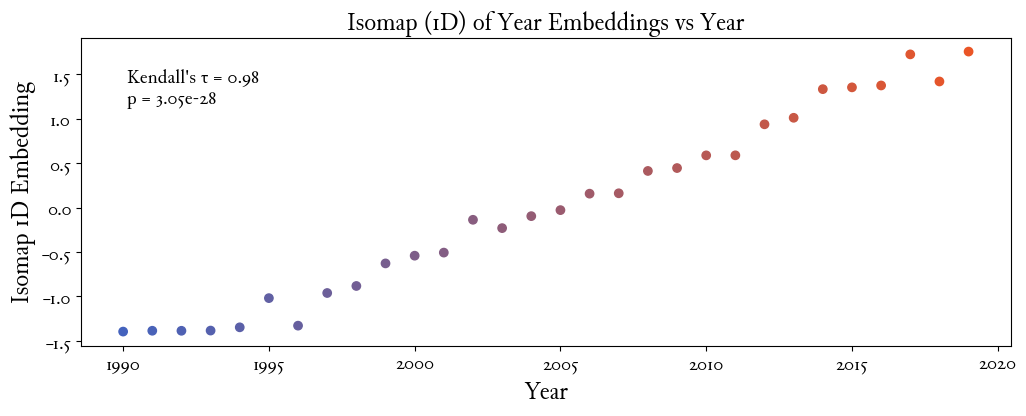

In [6]:
from sklearn.manifold import Isomap

# Assuming year_embeddings is the variable holding the embeddings
isomap = Isomap(n_components=1)
year_isomap_1d = isomap.fit_transform(year_matrix)

from scipy.stats import kendalltau

# Flatten the isomap embedding to a 1D array
isomap_1d_flat = year_isomap_1d[:, 0]

# Perform Kendall's tau test between the year order and the isomap order
tau, p_value = kendalltau(years, isomap_1d_flat)

print(f"Kendall's tau correlation between year and Isomap 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
urllib.request.urlretrieve(font_url, font_path)
junicode_prop = fm.FontProperties(fname=font_path)


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap from min to max colors
colors = [colorscale_min, colorscale_max]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

fig, ax = plt.subplots(figsize=(12, 4))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.scatter(years, year_isomap_1d[:, 0], c=years, cmap=custom_cmap)
plt.xlabel('Year', fontproperties=junicode_prop, fontsize=18)
plt.ylabel('Isomap 1D Embedding', fontproperties=junicode_prop, fontsize=18)
plt.title('Isomap (1D) of Year Embeddings vs Year', fontproperties=junicode_prop, fontsize=18)
plt.xticks(fontproperties=junicode_prop, fontsize=14)
plt.yticks(fontproperties=junicode_prop, fontsize=14)

# Add Kendall's tau annotation
plt.text(0.05, 0.90, f"Kendall's τ = {tau:.2f}\np = {p_value:.2e}", 
         transform=ax.transAxes, fontproperties=junicode_prop, fontsize=14,
         verticalalignment='top')

plt.show()


In [7]:
from sklearn.manifold import Isomap

# Assuming year_embeddings is the variable holding the embeddings
isomap = Isomap(n_components=1)
year_isomap_1d = isomap.fit_transform(year_matrix)

from scipy.stats import kendalltau

# Flatten the isomap embedding to a 1D array
isomap_1d_flat = year_isomap_1d[:, 0]

# Perform Kendall's tau test between the year order and the isomap order
tau, p_value = kendalltau(years, isomap_1d_flat)

print(f"Kendall's tau correlation between year and Isomap 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

import plotly.graph_objects as go
import plotly.express as px

# Create custom colorscale for plotly
custom_colorscale = [[0, colorscale_min], [1, colorscale_max]]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=years,
    y=year_isomap_1d[:, 0],
    mode='markers',
    marker=dict(
        color=years,
        colorscale=custom_colorscale,
        size=8,
        colorbar=dict(
            title=dict(
                text='Year',
                font=dict(family='Junicode, serif', size=14, color='black')
            ),
            tickfont=dict(family='Geist Mono', size=12, color='black'),
            x=1.02
        )
    ),
    hovertemplate='<span style="font-family: Geist Mono;">Year: %{x}<br>Isomap1D: %{y:.4f}</span><extra></extra>',
    showlegend=False
))

fig.update_layout(
    xaxis=dict(
        title=dict(
            text='Year',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    yaxis=dict(
        title=dict(
            text='Isomap Embedding',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    width=1000,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

# Add Kendall's tau annotation
fig.add_annotation(
    x=0.05,
    y=0.90,
    xref='paper',
    yref='paper',
    text=f"Kendall's τ = {tau:.2f}<br>p = {p_value:.2e}",
    showarrow=False,
    font=dict(family='Geist Mono', size=14, color='black'),
    align='left',
    valign='top'
)

# Save as HTML

config = {'displayModeBar': False}
fig.write_html("year_manifold_isomap.html", config=config)

fig.show()


Kendall's tau correlation between year and Isomap 1D embedding: 0.9816
P-value: 3.0480e-28
